# ResNet
加更多层不一定总是改进精度

### 残差块
- 串联一个层改变函数类，希望能扩大函数类
- 残差块加入快速通道来得到**$f(x)=x+g(x)$**的结构
- 不同的残差块
  - 卷积层、BatchNorm层和激活层，从哪里接进从哪里接出来都可以

### ResNet块
- **高宽减半ResNet块（步幅2）**
- **后接多个高宽不变ResNet块**

### ResNet架构
- 类似VGG和GoogleNet的总体架构
- 但替换成了ResNet块

### 总结
- 残差块使得**很深**的网络更加容易训练
  - 甚至可以训练一千层的网络（梯度不会消失，因为是加法）
- 残差网络对随后的深层网络设计产生了深远的影响，无论是卷积类网络还是全连接类网络
- 一般34用的比较多

## 代码

In [1]:
!pip install d2l

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

**ResNet**块细节
- 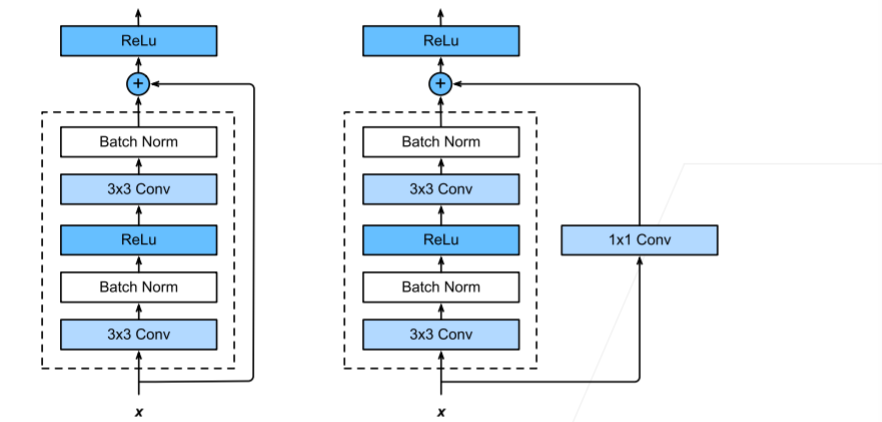
- 当**输出形状改变**时，必须要**使用$1\times1$的卷积**（使得输入`X`形状发生改变），才能够正确输出

In [3]:
class Residual(nn.Module):
  def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                 kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                   kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

**输入和输出形状一致**的情况

In [4]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

**增加输出通道的同时，减半输出的高和宽**
- 若没有`use_1x1conv=True`，`conv1`卷积层会将输入的张量的空间尺寸缩小一半，`Y`就会和`X`形状不匹配
- **`strides`不是1的话，就需要`use_1x1conv=True`**

In [5]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

#### ResNet模型
- ResNet的前两层跟之前介绍的GoogLeNet中的一样：
  - 在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
- 不同之处在于ResNet每个卷积层后增加了批量规范化层。
- GoogleNet在后面接了4个由Inception组成的模块；ResNet则使用4个由残差块组成的模块
  - **第一个**模块的**通道数同输入通道数一致**，无需减高宽
  - 之后的每个模块在第一个残差块里将上一个模块的**通道数翻倍**，并将**高宽减半**
- ``nn.AdaptiveAvgPool2d(output_size)`：
  - 其中`output_size`是一个整数或包含两个整数的元组，指定**输出的目标大小（高宽）**

In [4]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10)
)

In [7]:
X = torch.rand((1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


#### 过程
- 先由卷积层和最大池化层，使得高宽减四倍
- 第一个ResNet块先不变通道数与高宽
- 后三个ResNet块使得通道数加倍，高宽减半
- 加入全局平均池化层，与全连接层输出


#### 训练模型

loss 0.015, train acc 0.996, test acc 0.905
1509.0 examples/sec on cuda:0


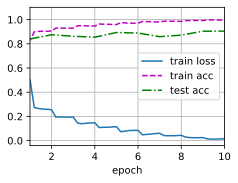

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习
1. Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
- 答
  - Inception块：包含多个并行路径，捕捉不同尺度的特征，最终在通道维度上被拼接在一起
  - 残差块：直接将输入与卷积层的输出相加（还可以解决深度网络中梯度消失问题）

2. ResNet的不同变体
3. 对于更深层次的网络，ResNet引入了'bottleneck'架构来降低模型复杂度
- 答
  - 基本块（BasicBlock），是一个标准卷积块
  - Bottleneck块，是一种高级结构，通常用于更深的ResNet版本——目标：减少计算量，同时保持网络的表达能力
  - 将两个结合到一起了

In [8]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, strides=1, downsample=None):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
    self.strides = strides

  def forward(self, X):
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.downsample is not None:
      X = self.downsample(X)
    Y += X
    return self.relu(Y)

- 第一层$1\times1$卷积：目的是降通道数，减少后续计算
- 第二层$3\times3$卷积：通道数不变
- 第三层$1\times1$卷积：恢复（增加）通道数

In [9]:
class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, strides=1, downsample=None):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=strides, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
    self.downsample = downsample
    self.strides = strides

  def forward(self, X):
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.relu(self.bn2(self.conv2(Y)))
    Y = self.relu(self.bn3(self.conv3(Y)))
    if self.downsample is not None:
      X = self.downsample(X)
    Y += X
    return self.relu(Y)

In [14]:
def make_layer(block, in_channels, out_channels, num_blocks, strides=1):
  downsample=None
  if strides !=1 or in_channels != out_channels * block.expansion:
    downsample = nn.Sequential(
        nn.Conv2d(in_channels, out_channels * block.expansion, kernel_size=1, bias=False),
        nn.BatchNorm2d(out_channels * block.expansion)
    )
  layer = []
  layer.append(block(in_channels, out_channels, strides, downsample))
  in_channels = out_channels * block.expansion
  for _ in range(1, num_blocks):
    layer.append(block(in_channels, out_channels))
  return nn.Sequential(*layer)

def resnet(arch):
  block, layers = {
      'resnet18':(BasicBlock, [2, 2, 2, 2]),
      'resnet34':(BasicBlock, [3, 4, 6, 3]),
      'resnet50':(Bottleneck, [3, 4, 6, 3])
  }[arch]
  b1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
  )
  b2 = make_layer(block, 64, 64, layers[0])
  b3 = make_layer(block, 64 * block.expansion, 128, layers[1], strides=2)
  b4 = make_layer(block, 128 * block.expansion, 256, layers[2], strides=2)
  b5 = make_layer(block, 256 * block.expansion, 512, layers[3], strides=2)
  net = nn.Sequential(
      b1,  b2, b3, b4, b5,
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(), nn.Linear(512 * block.expansion, 10)
  )
  return net

In [17]:
net = resnet('resnet50')
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

4. 在ResNet的后续版本中，作者将“卷积层、批量归一化层和激活层”架构更改为**“批量归一化层、激活层和卷积层”**架构。请尝试做这个改进

In [21]:
class Residual_new(nn.Module):
  def __init__(self, in_channels, out_channels, strides=1, use_1x1conv=False):
    super().__init__()
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if use_1x1conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None

  def forward(self, X):
    Y = self.conv1(self.relu(self.bn1(X)))
    Y = self.conv2(self.relu(self.bn2(Y)))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return Y

5. 为什么即使函数类是嵌套的，仍然要限制增加函数的复杂性
- 答
  - 因为过于复杂的函数会导致过拟合，从而降低模型的泛化能力

# DenseNet

- 执行从$\mathbf{x}$到其展开式的映射：
$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$
- 将这些展开式结合到多层感知计中，在此减少特征的数量

- **小结**
  - 在夸层连接上，不同于ResNet中将输入与输出相加，稠密连接网络（DenseNet）**在通道维上连结输入与输出**
  - DenseNet的主要构建模块是**稠密块**和**过渡层**
  - 在构建DenseNet时，我们需要通过添加过渡层来**控制网络的维数**，从而再次减少通道的数量



## 代码
#### 稠密块体
- DenseNet使用了ResNet改良版的“批量归一化、激活和卷积”架构
- 一个稠密块由多个卷积块组成
  - 每个卷积块使用**相同数量的输出通道**
  - 在向前传播中，将每个卷积块的输入和输出**在通道维上连结**

In [6]:
def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.BatchNorm2d(in_channels), nn.ReLU(),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
  )

class DenseBlock(nn.Module):
  def __init__(self, num_convs, in_channels, out_channels):
    super().__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(out_channels * i + in_channels, out_channels))
    self.net = nn.Sequential(*layer)

  def forward(self, X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X, Y), dim=1)
    return X

In [31]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

没法用一下的过程来得到维度变化，因为由`.cat`的过程

In [29]:
# X = torch.randn(1, 3, 96, 96)
# for layer in blk.net:
#   X = layer(X)
#   print(layer.__class__.__name__, 'shape:\t',X.shape)

Sequential shape:	 torch.Size([1, 10, 96, 96])


RuntimeError: running_mean should contain 10 elements not 13

#### 过渡层
- 因为每个稠密块都会带来通道数的增加，使用过多会过于复杂化模型
  - 通过$1\times1$卷积层来**减少通道数**
  - 使用步幅为2的平均池化层**减半高和宽**

In [7]:
def transition_block(in_channels, out_channels):
  return nn.Sequential(
      nn.BatchNorm2d(in_channels), nn.ReLU(),
      nn.Conv2d(in_channels, out_channels, kernel_size=1),
      nn.AvgPool2d(kernel_size=2, stride=2)
  )

In [32]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

#### DenseNet模型
- 首先使用同ResNet一样的单卷积层和最大汇聚层
- 接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块
  - 设置每个稠密快使用4个卷积层（从而和ResNet-18保持一致）
  - 稠密块里的卷积层通道数（即增长率）设置为32，故每个稠密块将增加128个通道
  

In [8]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs, num_channels, growth_rate))
  # 上一个稠密块的输出通道数
  num_channels += num_convs * growth_rate
  if i != len(num_convs_in_dense_blocks) - 1:
    blks.append(transition_block(num_channels, num_channels // 2))
    num_channels = num_channels // 2

In [35]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

#### 训练

loss 0.023, train acc 0.992, test acc 0.898
1512.9 examples/sec on cuda:0


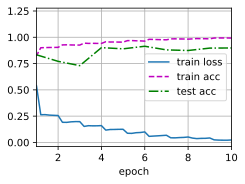

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习

1. 为什么在过渡层使用平均池化层而不是最大池化层
- 答
  - 因为平均池化层可以更好的保留特征图中的信息，而最大池化层会丢失一些信息

2. DenseNet的优点之一是其模型参数比ResNet小，为什么
- 答
  - 能够复用前层的特征，减少了重复的特征学习需求，且通过较小的增长率限制了通道数的增加
  - ResNet通过跳跃连接，使每一层能访问初始输入，但每一层仍独立生成新的特征

3. DenseNet一个诟病的问题是内存或显存消耗过多。
  - 真的是这样吗？可以把输入形状换成$224\times224$，来看看实际的显存消耗。
  - 有另一种方法来减少显存消耗吗？需要改变框架么？

##### 4. 实现DenseNet论文[71]表1所示的不同DenseNet版本

In [12]:
class DenseNet(nn.Module):
  def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4), num_classes=10):
    super().__init__()
    self.b1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
      nn.BatchNorm2d(64), nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    net = [self.b1]
    for i, num_convs in enumerate(arch):
      net.append(DenseBlock(num_convs, num_channels, growth_rate))
      num_channels += num_convs * growth_rate
      if i != len(arch) - 1:
        net.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
    net.append(
        nn.Sequential(
          nn.BatchNorm2d(num_channels),
          nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)),
          nn.Flatten(),
          nn.Linear(num_channels, num_classes)
          )
    )
    self.net = nn.Sequential(*net)

  def forward(self, X):
    return self.net(X)

def densnet(arch_name):
  arch_layers = {
    'densenet121': [6, 12, 24, 16],
    'densenet169': [6, 12, 32, 32],
    'densenet201': [6, 12, 48, 32],
    }
  return DenseNet(arch=arch_layers[arch_name])

In [22]:
net = densnet('densenet121')
print(net)

DenseNet(
  (b1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_runni

5. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于4.10节中的房价预测任务
**还没有看！**

In [25]:
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
    def preprocess(self):
      # Remove the ID and label columns
      label = 'SalePrice'
      features = pd.concat(
          (self.raw_train.drop(columns=['Id', label]),
          self.raw_val.drop(columns=['Id'])))
      # Standardize numerical columns
      numeric_features = features.dtypes[features.dtypes!='object'].index
      features[numeric_features] = features[numeric_features].apply(
          lambda x: (x - x.mean()) / (x.std()))
      # Replace NAN numerical features by 0
      features[numeric_features] = features[numeric_features].fillna(0)
      # Replace discrete features by one-hot encoding
      features = pd.get_dummies(features, dummy_na=True)
      # Save preprocessed features
      self.train = features[:self.raw_train.shape[0]].copy()
      self.train[label] = self.raw_train[label]
      self.val = features[self.raw_train.shape[0]:].copy()

    def get_dataloader(self, train):
      label = 'SalePrice'
      data = self.train if train else self.val
      if label not in data: return
      get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                        dtype=torch.float32)
      # Logarithm of prices
      tensors = (get_tensor(data.drop(columns=[label])),  # X
                torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
      return self.get_tensorloader(tensors, train)


In [26]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [27]:
data.preprocess()
data.train.shape

(1460, 331)

In [28]:
def k_fold_data(data, k):
  rets = []
  fold_size = data.train.shape[0] // k
  for j in range(k):
    idx = range(j * fold_size, (j + 1) * fold_size)
    rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))
  return rets

In [29]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.17282628089189528


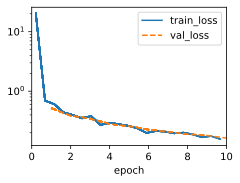

In [30]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [31]:
class HouseDenMLP(d2l.LinearRegression):
    def __init__(self, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.p0 = nn.Flatten()
        self.p1 = nn.Sequential(nn.LazyLinear(64),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p2 = nn.Sequential(nn.LazyLinear(32),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.p3 = nn.Sequential(nn.LazyLinear(16),
                    nn.LazyBatchNorm1d(),
                    nn.ReLU(),
                    nn.Dropout(0.05))
        self.net = nn.Sequential(self.p1,
                    self.p2,
                    self.p3,
                    nn.LazyLinear(1))

    def forward(self, X):
        X = self.net[0](X)
        for blk in self.net[1:-1]:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return self.net[-1](X)


In [32]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = HouseDenMLP(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.4014275532960891


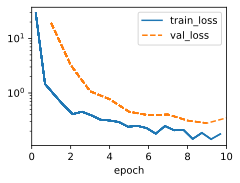

In [33]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)